In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.seed_everything(0)

In [3]:
EXPERIMENT_NAME = '1130-LSTM-win120-W'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 120

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile, window_size, stride):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size
        
        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            self.indexes.append((i, i + window_size))
            i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        sx, tx = self.indexes[idx]
        sy, ty = sx + WINDOW_SIZE, tx + WINDOW_SIZE
        x = self.csv.iloc[sx:tx][self.xcols].to_numpy()
        y = self.csv.iloc[sy:ty][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 300, 3

        return x, y

In [6]:
ds_train = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [7]:
len(ds_train), len(ds_test)

(11071, 10671)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([120, 6]), torch.Size([120, 3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape

torch.Size([120, 6])

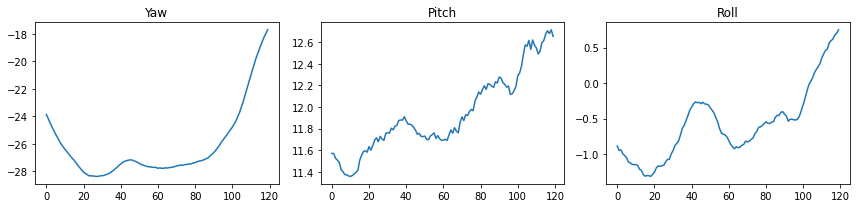

In [11]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.plot(x[:, 0])
plt.title('Yaw')

plt.subplot(1, 3, 2)
plt.plot(x[:, 1])
plt.title('Pitch')

plt.subplot(1, 3, 3)
plt.plot(x[:, 2])
plt.title('Roll')

plt.tight_layout()
plt.show()

# 모델 생성

StackedLSTM Bidirectional

In [12]:
class M2M_LSTM(nn.Module):
    def __init__(self):
        super(M2M_LSTM, self).__init__()

        self.rnn = nn.LSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           batch_first=True,
                           dropout=0.2,
                           bidirectional=True)

        self.out = nn.LSTM(input_size=128, 
                           hidden_size=3, 
                           num_layers=1, 
                           batch_first=True, 
                           dropout=0, 
                           bidirectional=False)
        self.fc = nn.Linear(128, 3)

    def forward(self, x):
        x, (hiddens, cells) = self.rnn(x) # B, S, 128
        #x, (hiddens, cells) = self.out(x) # B, S, 3
        hs = []
        for i in range(x.shape[1]):
            h = self.fc(x[:, i])
            hs.append(h)
        h = torch.stack(hs, 1)

        return h

In [13]:
model = M2M_LSTM().cuda()

In [14]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [15]:
class HPMetric(tb.metrics.InvisibleMetric):
    def __init__(self, name: str):
        super(HPMetric, self).__init__(name)

        self.diff = []

    def on_valid_epoch_end(self, epoch: int, logs: dict):
        # RMS, 99% tile 출력
        yaw_v, pitch_v, roll_v, rms_v, tile99_v = self._calc_values(self.diff)

        print(f'                  validation')
        print(f' - Yaw          : {yaw_v:10f}')
        print(f' - Pitch        : {pitch_v:10f}')
        print(f' - Roll         : {roll_v:10f}')
        print(f' - RMS          : {rms_v:10f}')
        print(f' - 99% Tile     : {tile99_v:10f}')

        self.diff.clear()

    def get_value(self, outputs: torch.Tensor, targets: torch.Tensor, is_train: bool):
        if not is_train:
            self.diff.append((outputs - targets).mean(1).detach().cpu())  # (B, S, 3) --> (B, 3)

    @staticmethod
    def _calc_values(diff):
        diff = torch.cat(diff).abs_()  # (D, 3)
        rms = (diff.square().sum(1) / 3).sqrt()
        tile = rms.flatten().numpy()
        tile99 = np.percentile(tile, 99)
        
        mrms = rms.mean()
        
        # diff = radian2degree(diff)
        #tile = diff.flatten().numpy()
        #tile99 = np.percentile(tile, 99)

        mdiff = diff.mean(dim=0)
        #rms = (mdiff.square().sum() / 3).sqrt()

        return mdiff[0].item(), mdiff[1].item(), mdiff[2].item(), mrms.item(), tile99

In [16]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           HPMetric('hp_metric')]

In [17]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0], patience=3),
             tb.callbacks.SaveCheckpoint({'model': model}, metrics[0], CHECKPOINT_DIR, 'best-ckpt.pth')]

In [18]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [19]:
trainer.fit(ds_train, ds_test, num_epochs=200, batch_size=256, shuffle=True, pin_memory=True)

[0002/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from inf to 234.8572193327404
                  validation
 - Yaw          :  18.123629
 - Pitch        :  10.170142
 - Roll         :   2.416254
 - RMS          :  13.009292
 - 99% Tile     :  26.812298


[0003/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 234.8572193327404 to 208.33988307771227
                  validation
 - Yaw          :  16.963274
 - Pitch        :   8.630249
 - Roll         :   2.569400
 - RMS          :  11.956036
 - 99% Tile     :  25.930684


[0004/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 208.33988307771227 to 179.04213156018935
                  validation
 - Yaw          :  15.031378
 - Pitch        :   8.092386
 - Roll         :   2.451120
 - RMS          :  10.848778
 - 99% Tile     :  24.017681


[0005/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 179.04213156018935 to 159.349886122204
                  validation
 - Yaw          :  13.593430
 - Pitch        :   8.159460
 - Roll         :   2.350868
 - RMS          :  10.158207
 - 99% Tile     :  22.578028


[0006/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 159.349886122204 to 147.29230785369873
                  validation
 - Yaw          :  12.479218
 - Pitch        :   7.936607
 - Roll         :   2.362994
 - RMS          :   9.564082
 - 99% Tile     :  22.126282


[0007/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 147.29230785369873 to 142.48010926019577
                  validation
 - Yaw          :  12.335450
 - Pitch        :   7.688199
 - Roll         :   2.390121
 - RMS          :   9.403228
 - 99% Tile     :  22.261943


[0008/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 142.48010926019577 to 134.06492664700463
                  validation
 - Yaw          :  11.643262
 - Pitch        :   7.317278
 - Roll         :   2.345167
 - RMS          :   8.934312
 - 99% Tile     :  22.015236


[0009/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 134.06492664700463 to 129.8515812555949
                  validation
 - Yaw          :  11.606878
 - Pitch        :   7.053999
 - Roll         :   2.359782
 - RMS          :   8.753055
 - 99% Tile     :  21.735670


[0010/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 129.8515812555949 to 124.6659334727696
                  validation
 - Yaw          :  10.985590
 - Pitch        :   6.963596
 - Roll         :   2.343364
 - RMS          :   8.474321
 - 99% Tile     :  22.954729


[0011/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 124.6659334727696 to 123.07436613809494
                  validation
 - Yaw          :  10.483807
 - Pitch        :   6.912482
 - Roll         :   2.352568
 - RMS          :   8.249300
 - 99% Tile     :  22.986056


[0012/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 123.07436613809494 to 118.76910037086124
                  validation
 - Yaw          :  10.405332
 - Pitch        :   6.764382
 - Roll         :   2.333049
 - RMS          :   8.133216
 - 99% Tile     :  22.637943


[0013/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :  10.332128
 - Pitch        :   6.966147
 - Roll         :   2.360541
 - RMS          :   8.198252
 - 99% Tile     :  23.627316


[0014/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :  10.629911
 - Pitch        :   6.850261
 - Roll         :   2.370431
 - RMS          :   8.239637
 - 99% Tile     :  24.104326


[0015/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 118.76910037086124 to 116.33290958404541
                  validation
 - Yaw          :  10.033653
 - Pitch        :   6.676668
 - Roll         :   2.362273
 - RMS          :   7.946792
 - 99% Tile     :  23.436222


[0016/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :  10.155171
 - Pitch        :   6.795320
 - Roll         :   2.369572
 - RMS          :   8.027666
 - 99% Tile     :  24.650526


[0017/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :  10.020475
 - Pitch        :   6.698265
 - Roll         :   2.337438
 - RMS          :   7.966706
 - 99% Tile     :  23.678887


[0018/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 116.33290958404541 to 115.99461033230736
                  validation
 - Yaw          :   9.729050
 - Pitch        :   6.851598
 - Roll         :   2.359937
 - RMS          :   7.886282
 - 99% Tile     :  23.982642


[0019/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :  10.015954
 - Pitch        :   6.914218
 - Roll         :   2.411399
 - RMS          :   8.030788
 - 99% Tile     :  24.133780


[0020/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :  10.017655
 - Pitch        :   6.764608
 - Roll         :   2.354153
 - RMS          :   7.977889
 - 99% Tile     :  24.771081


[0021/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 115.99461033230736 to 112.84787564050583
                  validation
 - Yaw          :   9.552552
 - Pitch        :   6.647446
 - Roll         :   2.330761
 - RMS          :   7.798288
 - 99% Tile     :  23.681954


[0022/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :  13.601236
 - Pitch        :   6.966919
 - Roll         :   2.621899
 - RMS          :   9.827044
 - 99% Tile     :  24.691393


[0023/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 112.84787564050583 to 108.78234627133324
                  validation
 - Yaw          :   9.035360
 - Pitch        :   6.547195
 - Roll         :   2.347222
 - RMS          :   7.445752
 - 99% Tile     :  23.919940


[0024/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 108.78234627133324 to 106.05092489151727
                  validation
 - Yaw          :   8.798159
 - Pitch        :   6.436257
 - Roll         :   2.327174
 - RMS          :   7.340775
 - 99% Tile     :  23.569200


[0025/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   9.364354
 - Pitch        :   6.526609
 - Roll         :   2.384654
 - RMS          :   7.650433
 - 99% Tile     :  24.418939


[0026/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   9.162897
 - Pitch        :   6.390954
 - Roll         :   2.372711
 - RMS          :   7.475661
 - 99% Tile     :  24.201231


[0027/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   8.985515
 - Pitch        :   6.458461
 - Roll         :   2.347829
 - RMS          :   7.406697
 - 99% Tile     :  23.438024


[0028/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 106.05092489151727 to 104.82261217208136
                  validation
 - Yaw          :   9.049468
 - Pitch        :   6.281147
 - Roll         :   2.283638
 - RMS          :   7.339723
 - 99% Tile     :  23.490273


[0029/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :  12.052214
 - Pitch        :   6.648990
 - Roll         :   2.449899
 - RMS          :   8.966542
 - 99% Tile     :  25.066219


[0030/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   9.071419
 - Pitch        :   6.622771
 - Roll         :   2.324009
 - RMS          :   7.514009
 - 99% Tile     :  23.950128


[0031/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 104.82261217208136 to 104.48387277693976
                  validation
 - Yaw          :   8.861389
 - Pitch        :   6.430037
 - Roll         :   2.236537
 - RMS          :   7.326540
 - 99% Tile     :  23.380680


[0032/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   8.874451
 - Pitch        :   6.562255
 - Roll         :   2.272668
 - RMS          :   7.377920
 - 99% Tile     :  24.030107


[0033/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   8.824788
 - Pitch        :   6.488409
 - Roll         :   2.287672
 - RMS          :   7.351226
 - 99% Tile     :  24.040376


[0034/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   9.140822
 - Pitch        :   6.528799
 - Roll         :   2.234375
 - RMS          :   7.503986
 - 99% Tile     :  23.614597


[0035/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   9.073482
 - Pitch        :   6.461409
 - Roll         :   2.256889
 - RMS          :   7.434694
 - 99% Tile     :  23.928675


[0036/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   9.011786
 - Pitch        :   6.514910
 - Roll         :   2.245079
 - RMS          :   7.414965
 - 99% Tile     :  23.879026


[0037/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 3 epochs
val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   9.500599
 - Pitch        :   6.397901
 - Roll         :   2.253918
 - RMS          :   7.574953
 - 99% Tile     :  24.784553


[0038/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   9.096658
 - Pitch        :   6.439346
 - Roll         :   2.264833
 - RMS          :   7.424590
 - 99% Tile     :  23.885072


[0039/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   9.171767
 - Pitch        :   6.396278
 - Roll         :   2.257360
 - RMS          :   7.452081
 - 99% Tile     :  23.990645


[0040/0200] Train:   0%|                                                     | 0/44 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   9.156955
 - Pitch        :   6.440069
 - Roll         :   2.294255
 - RMS          :   7.477559
 - 99% Tile     :  24.365310


[0040/0200] Validation: 100%|████████████████████| 42/42 [00:02<00:00, 18.76it/s, val_loss 107.6449]

val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   9.111243
 - Pitch        :   6.473770
 - Roll         :   2.257795
 - RMS          :   7.455228
 - 99% Tile     :  24.046020
